#### imports

In [1]:
# Data preprocessing
import numpy as np
import pandas as pd 

import datetime

import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import cv2
import tensorflow as tf
print(tf.__version__) # print the version of tensorflow
print(tf.config.list_physical_devices('GPU')) # check if gpu is available

from sklearn.model_selection import train_test_split

# importing tqdm
from tqdm import tqdm


import keras
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, InputLayer , Activation , ZeroPadding2D , AveragePooling2D
from keras.metrics import categorical_crossentropy , categorical_accuracy
from keras.optimizers import SGD , Adam , RMSprop 


c:\Users\Shehab\.conda\envs\tensor37\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data_dir = 'COVID-19_Radiography_Dataset'


batch_size = 64
# img_height = 128
# img_width = 128
IMG_SIZE = 227 # for AlexNet

num_classes = 4

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# class_names = ['COVID','Normal']


#### helper functions

In [35]:
# helper functions 
def read_img(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def show_image(image, title='Image', cmap_type='gray', bgr2rgb=False):
    if bgr2rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.show()



def plot_model_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    
    
#       label = (label_batch[i])
#   plt.title(class_names[np.argmax(label)])
    
    
    
def show_predictions(model):
        # model predicting on validation data and plotting the images with their predicted labels and actual labels
    image_batch, label_batch = next(iter(val_ds))
    # image_batch, label_batch = val_ds.batch(2)
    predicted_batch = model.predict(image_batch)
    predicted_id = np.argmax(predicted_batch, axis=-1)
    # print(predicted_id)
    plt.figure(figsize=(15, 15))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')
        label = np.argmax(label_batch[i])
        predicted_label = int(predicted_id[i])
        color = "blue" if predicted_label == label else "red"
        plt.title(
            f'{class_names[label]} | {class_names[predicted_label]}', color=color, fontsize=10)
        plt.axis("off")
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
    plt.show()
# tensorboard callback



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)



resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2), 
#   tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
#   tf.keras.layers.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])



#### preprocessing data

##### method 1 of processing data  \\\\ NOT USED

In [4]:
x , y = [],[]
for path in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir,path)):
        img = cv2.imread(os.path.join(data_dir,path,img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        x.append(img)
        y.append(class_names.index(path))


In [5]:
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)
print(set(y))

(21165, 227, 227)
(21165,)
{0, 1, 2, 3}


In [6]:
# split data into train and test
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42 , shuffle=True)

In [7]:

data_dict = {'x_train': x_train,
             'y_train': y_train,
             'x_test': x_test,
             'y_test': y_test}
np.save('data_dict_227.npy', data_dict)


In [8]:
data_dict_ = np.load('data_dict_227.npy', allow_pickle=True).item()
x_train = data_dict_['x_train']
y_train = data_dict_['y_train']
x_test = data_dict_['x_test']
y_test = data_dict_['y_test']
del data_dict_

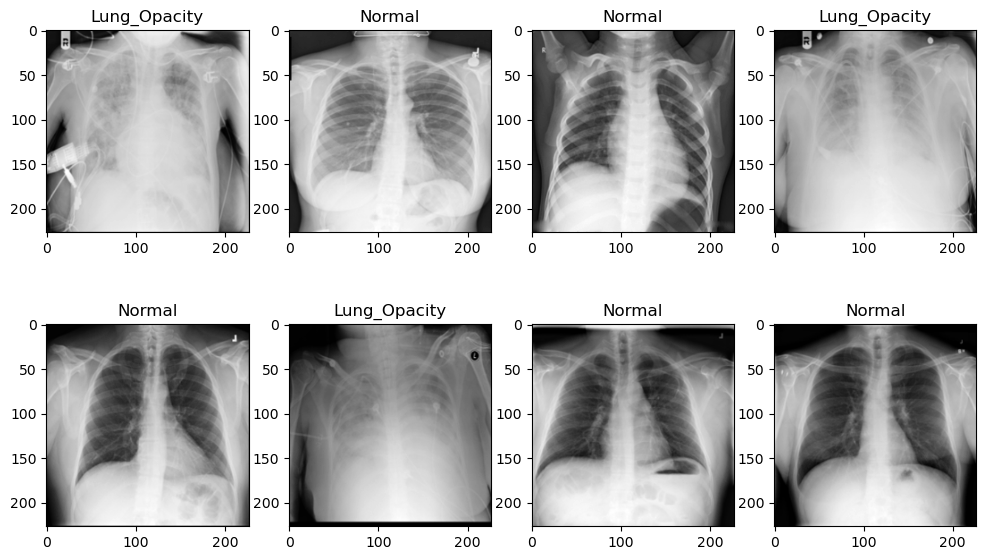

In [10]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(12, 7))
for i in range(8):
  ind = random.randint(0, len(x_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(x_train[ind] , cmap='gray')
  plt.title(class_names[y_train[ind]])


In [11]:
# importing one hot encoding from keras
def preprocess_data(X, y):
  # convert X from list to array
  x = np.array(X)

  # convert integer values of X into floats
  X = X.astype(np.float32)

  # normalization
  X = X/255.0

  # one-hot encoding the labels
  y = to_categorical(np.array(y))

  return X, y


(x_train, y_train) = preprocess_data(x_train, y_train)
(x_test, y_test) = preprocess_data(x_test, y_test)


##### another way to load data from directory using keras 


In [17]:
# another way to load data from directory using keras 
from tensorflow import keras
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory  = data_dir,
    labels = 'inferred',
    label_mode='categorical',
    class_names= class_names,
    validation_split=0.2,
    subset="training",
    seed=123,
    # image_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size)  
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory  = data_dir,
    labels = 'inferred',
    label_mode='categorical',

    class_names= class_names,
    validation_split=0.2,
    subset="validation",
    seed=123,
    # image_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size)  


Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [18]:
train_ds


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [19]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    # print((labels_batch))
    break


(64, 256, 256, 1)
(64, 4)


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


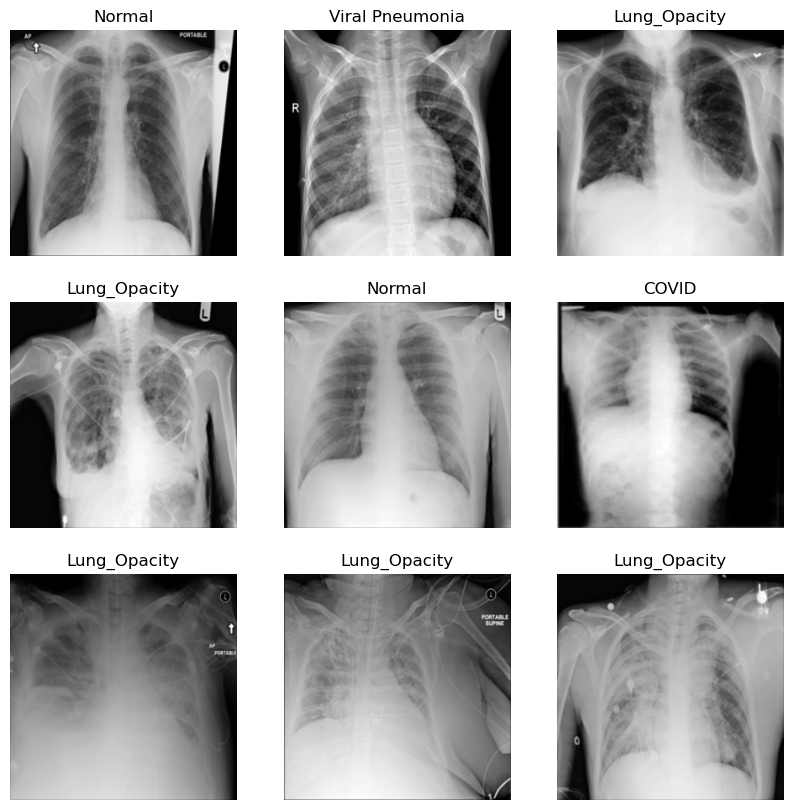

In [21]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')
  label = (label_batch[i])
  plt.title(class_names[np.argmax(label)])
  plt.axis("off")


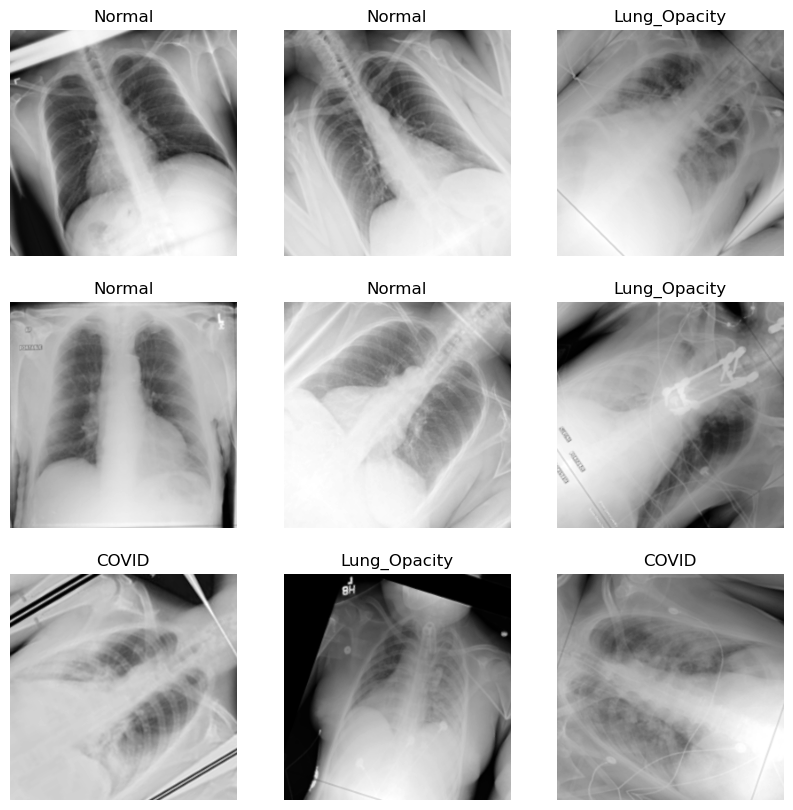

In [22]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  
  aug_batch = data_augmentation(image_batch, training=True)
  
  plt.imshow(aug_batch[i].numpy().astype("uint8"), cmap='gray')
  label = (label_batch[i])
  plt.title(class_names[np.argmax(label)])
  plt.axis("off")


#### simple cnn model

In [23]:


simple_cnn_model = tf.keras.Sequential([
    InputLayer(input_shape=(256 , 256 ,1)),

    resize_and_rescale,
    data_augmentation,
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes , activation='softmax')
])


In [24]:
simple_cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 227, 227, 1)       0         
                                                                 
 sequential_7 (Sequential)   (None, None, None, 1)     0         
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      9248      
                                                      

In [ ]:
simple_cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


In [25]:
epochs = 20

simple_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback])


# model.summary()



Epoch 1/20
265/265 [==============================] - 30s 92ms/step - loss: 1.0977 - accuracy: 0.5333 - val_loss: 0.9786 - val_accuracy: 0.6220
Epoch 2/20
265/265 [==============================] - 22s 81ms/step - loss: 0.8851 - accuracy: 0.6273 - val_loss: 0.8755 - val_accuracy: 0.6532
Epoch 3/20
265/265 [==============================] - 21s 78ms/step - loss: 0.8316 - accuracy: 0.6604 - val_loss: 0.8503 - val_accuracy: 0.6596
Epoch 4/20
265/265 [==============================] - 21s 79ms/step - loss: 0.7885 - accuracy: 0.6781 - val_loss: 0.7949 - val_accuracy: 0.6945
Epoch 5/20
265/265 [==============================] - 21s 79ms/step - loss: 0.7529 - accuracy: 0.6938 - val_loss: 0.8107 - val_accuracy: 0.6730
Epoch 6/20
265/265 [==============================] - 21s 80ms/step - loss: 0.7167 - accuracy: 0.7101 - val_loss: 0.8738 - val_accuracy: 0.6355
Epoch 7/20
265/265 [==============================] - 21s 81ms/step - loss: 0.6990 - accuracy: 0.7206 - val_loss: 0.8026 - val_accuracy:

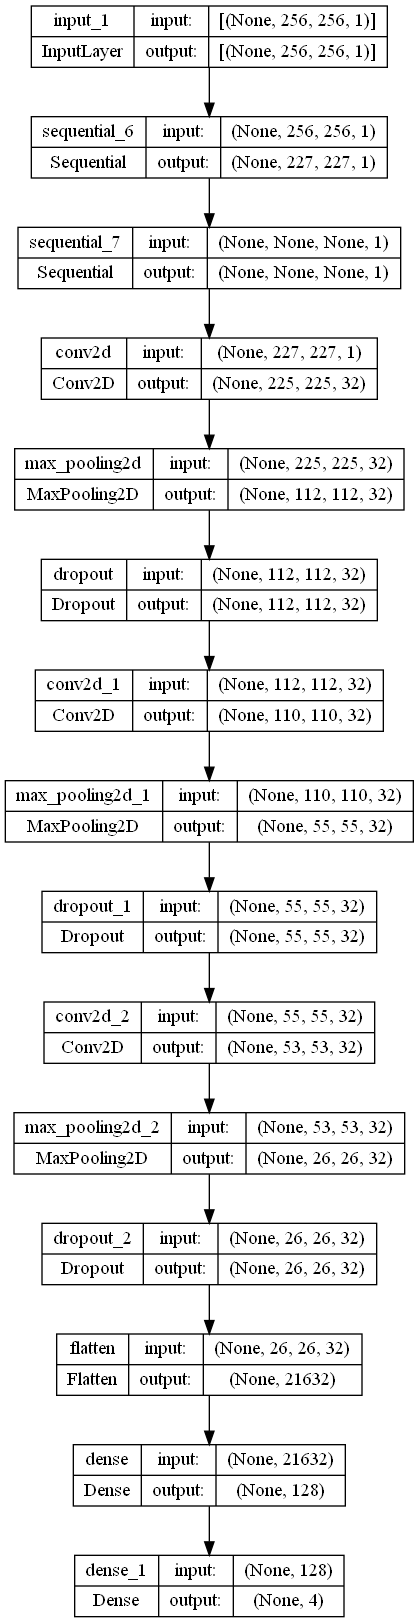

In [56]:
plot_model(simple_cnn_model, show_shapes=True, show_layer_names=True , to_file='simple_cnn_model.png')


In [50]:
plot_model_metrics(simple_cnn_model.history)

# show_predictions(simple_cnn_model)


KeyError: 'accuracy'

2/2 [==============================] - 0s 264ms/step


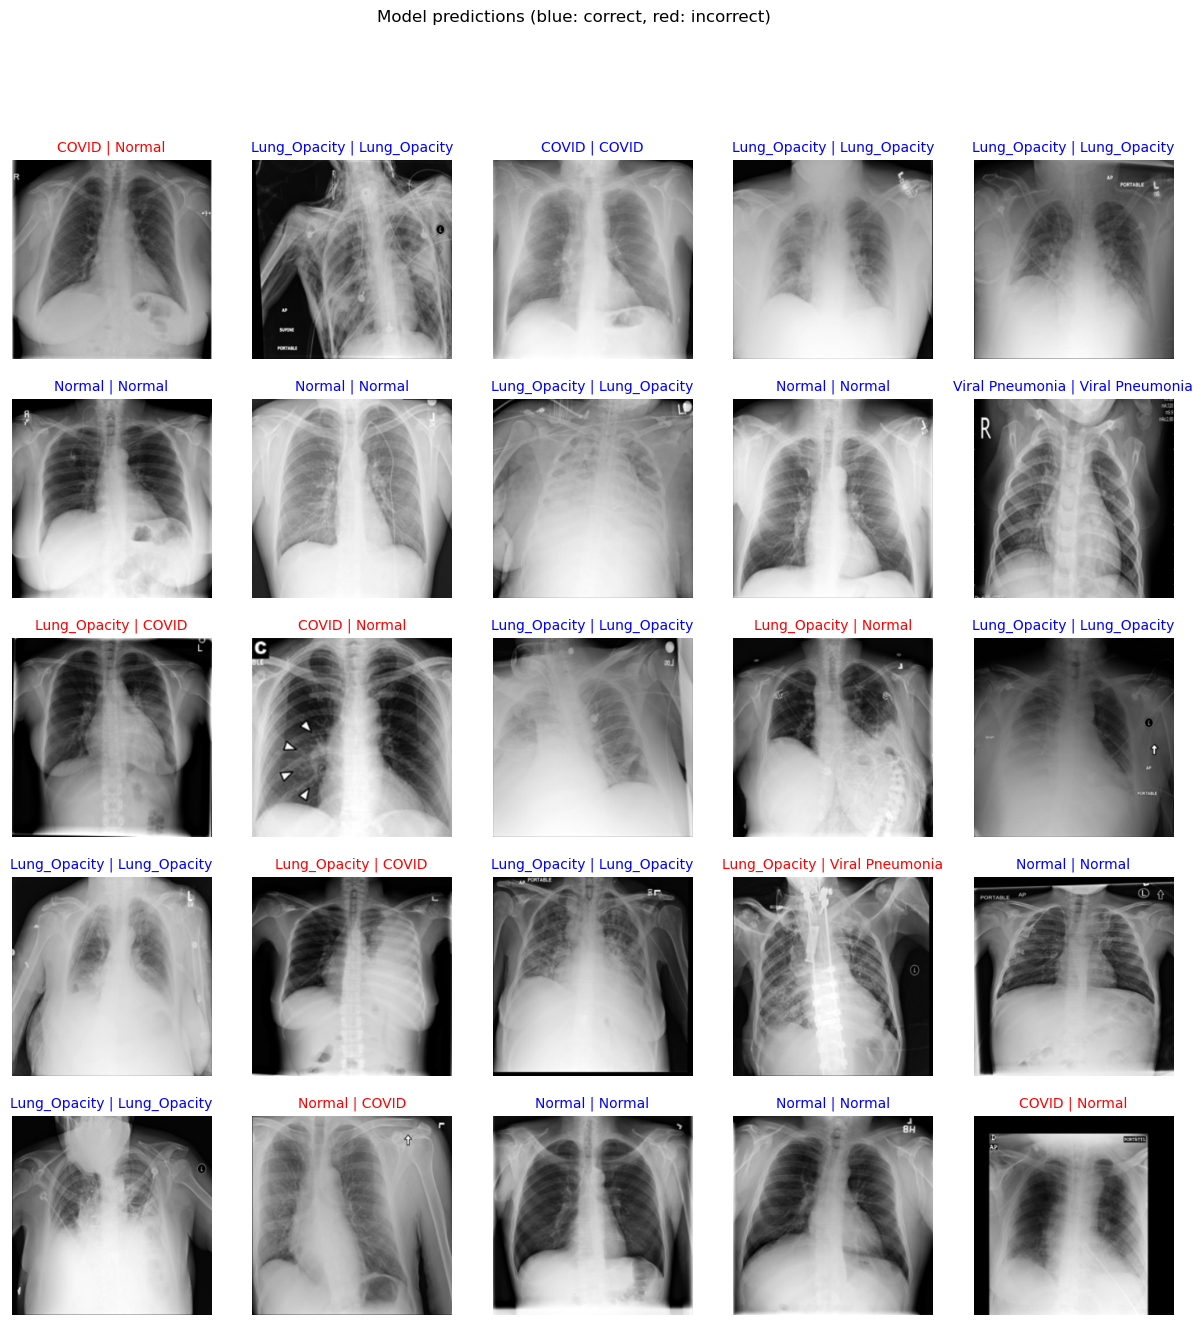

In [36]:
show_predictions(simple_cnn_model)


In [37]:
simple_cnn_model.save(f'simple_cnn_model_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')
# simple_cnn_model = tf.keras.models.load_model('simple_cnn_model.h5')

#### alex net

In [44]:
# ALEX net


alex_net = Sequential([
InputLayer(input_shape=(256 , 256 ,1)),

resize_and_rescale,
data_augmentation,
# layer 1: convolutional layer + max-pooling layer
Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu'),
MaxPooling2D(pool_size=(3, 3), strides=2),

# layer 2: convolutional layer + max-pooling layer 
Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'),
MaxPooling2D(pool_size = (3,3), strides = 2),

# layers 3-5: three convolutional layers + 1 max-pooling layer
Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
MaxPooling2D(pool_size=(3, 3), strides=2),

# layers 6 - 8: two fully connected hidden layers and one fully connected output layer
Flatten(),
Dense(4096, activation='relu'),
Dropout(0.5),
Dense(4096, activation='relu'),
Dropout(0.5),
Dense(num_classes , activation='softmax')])

alex_net.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 227, 227, 1)       0         
                                                                 
 sequential_12 (Sequential)  (None, 227, 227, 1)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                 

In [ ]:
alex_net.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])



In [51]:
epochs = 50
    
alex_net.fit(   
    train_ds,   
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback])


Epoch 1/50
265/265 [==============================] - 33s 125ms/step - loss: 0.4179 - accuracy: 0.8438 - val_loss: 0.3989 - val_accuracy: 0.8476
Epoch 2/50
265/265 [==============================] - 38s 143ms/step - loss: 0.4126 - accuracy: 0.8430 - val_loss: 0.4155 - val_accuracy: 0.8403
Epoch 3/50
265/265 [==============================] - 36s 136ms/step - loss: 0.4131 - accuracy: 0.8450 - val_loss: 0.4440 - val_accuracy: 0.8342
Epoch 4/50
265/265 [==============================] - 35s 129ms/step - loss: 0.4112 - accuracy: 0.8455 - val_loss: 0.4145 - val_accuracy: 0.8436
Epoch 5/50
265/265 [==============================] - 33s 123ms/step - loss: 0.4068 - accuracy: 0.8480 - val_loss: 0.4283 - val_accuracy: 0.8365
Epoch 6/50
265/265 [==============================] - 31s 116ms/step - loss: 0.4111 - accuracy: 0.8460 - val_loss: 0.4117 - val_accuracy: 0.8446
Epoch 7/50
265/265 [==============================] - 32s 120ms/step - loss: 0.4146 - accuracy: 0.8447 - val_loss: 0.4067 - val_ac

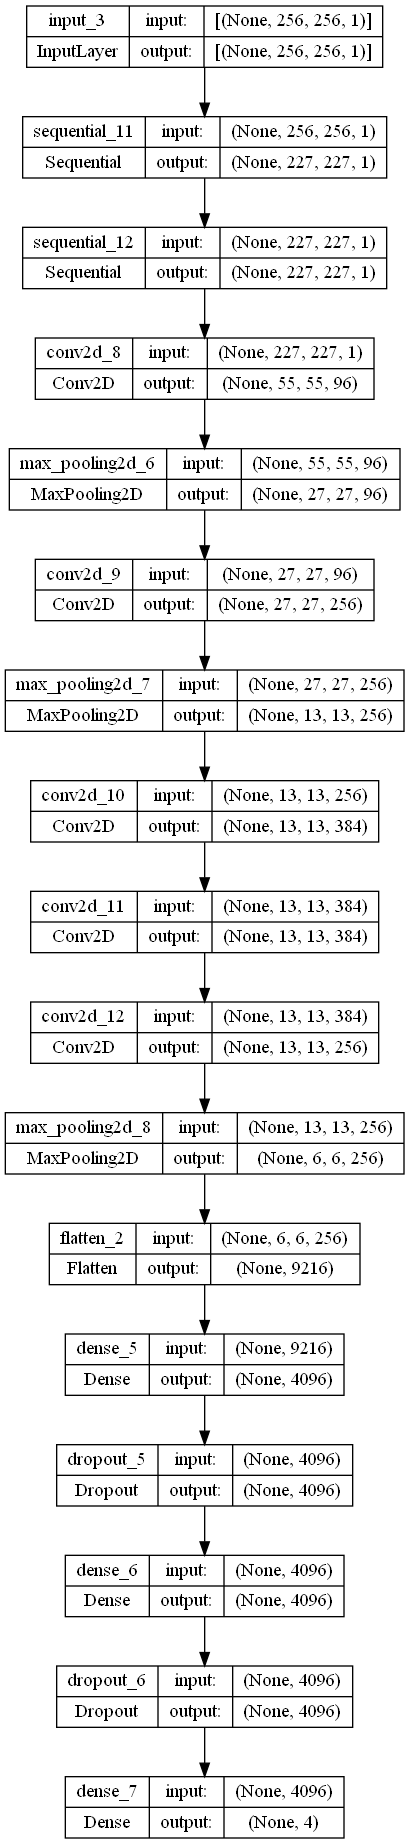

In [55]:
plot_model(alex_net, show_shapes=True, show_layer_names=True , to_file='alex_net.png')


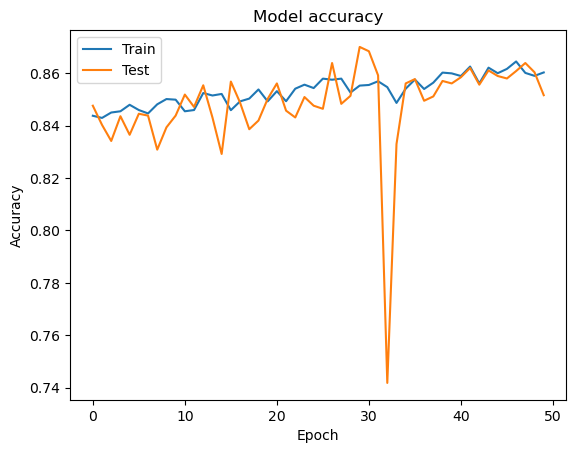

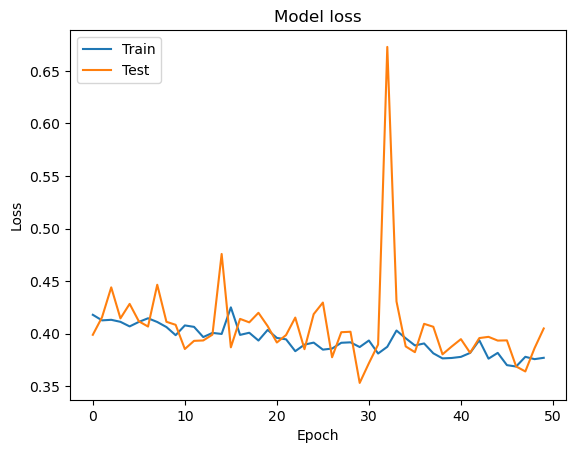

In [52]:
plot_model_metrics(alex_net.history)


2/2 [==============================] - 0s 83ms/step


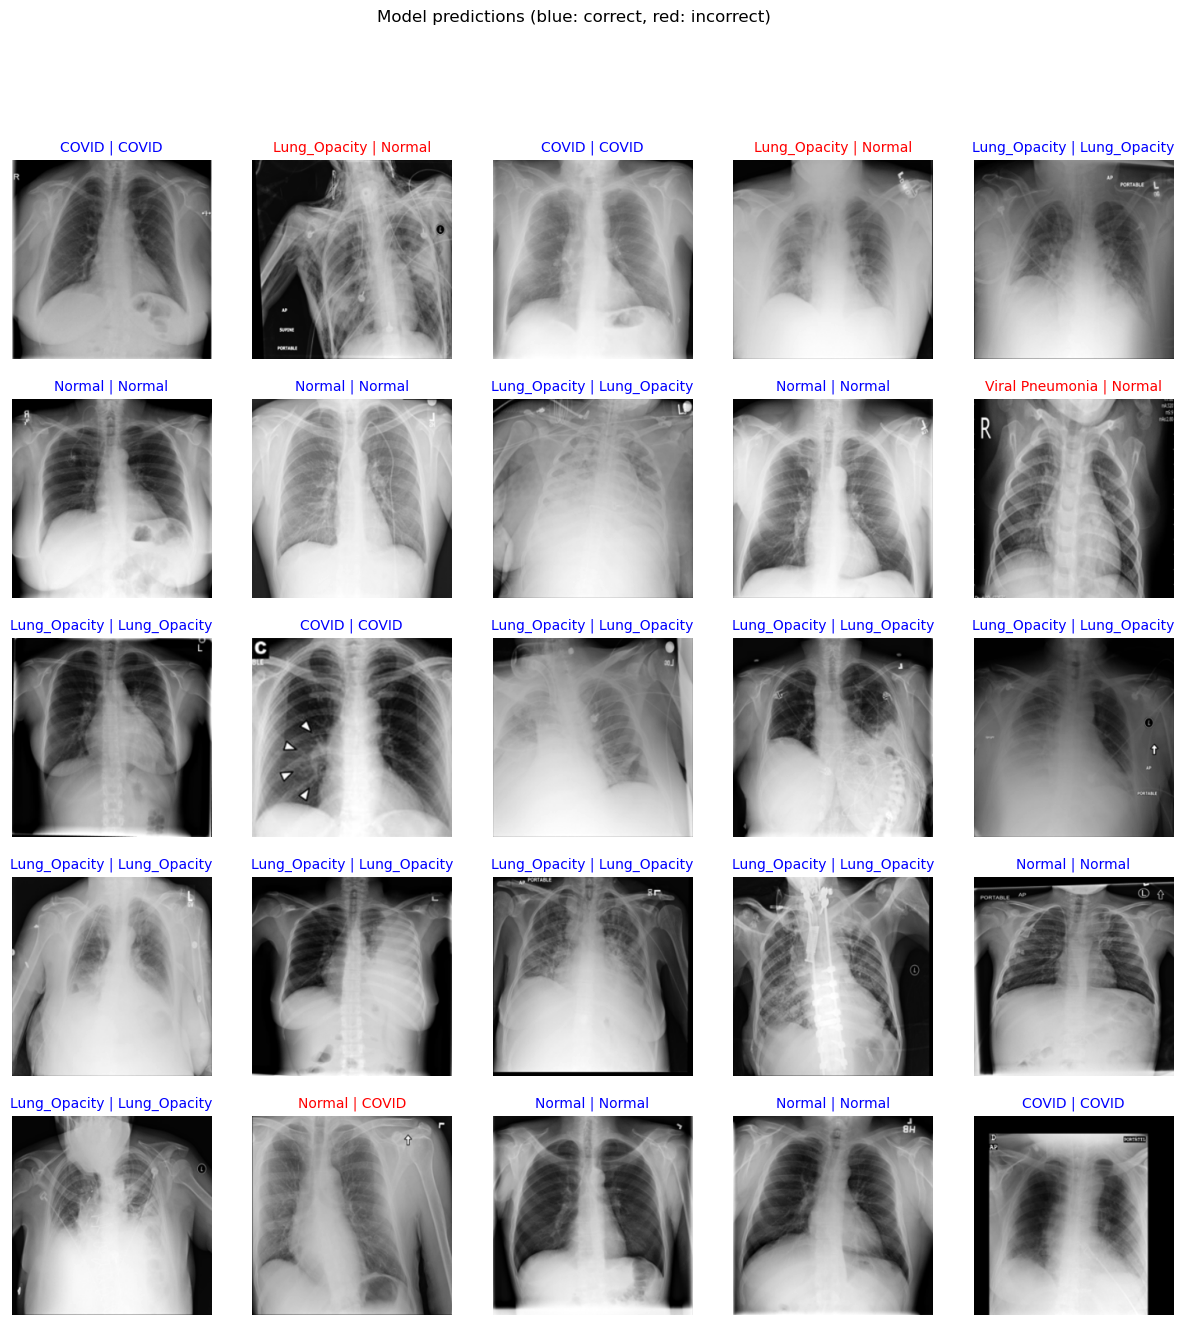

In [53]:
show_predictions(alex_net)

In [54]:
# saving the model with current timestamp
alex_net.save(f'alex_net_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')
# del alex_net


In [ ]:
# loading the model 
# alex_net = tf.keras.models.load_model('alex_net_20220930-103823.h5')


#### VGG net

#### other